### EDA Notebook - Sec Filings 10-K Dataset. 

#### Doc Owner - Joel Markapudi.
#### Date - 05/10/2024.

#### Plan for notebook EDA: (potentially)

1. Schema of dataset ovevrview, Column overview, etc.
2. Company stats, Temporal coverage/stats (yearly filings, etc.), Sentence Distribution stats.
3. Section Mapping & Distribution, Section breakdown, Text by Section stats, Common N-Grams (Top 20) ??
4. Missing data, Missing data patterns, Cardinality analysis. (heatmaps, etc.)
5. Data Quality flags, Edge cases. 

### High level plan for now.
```
     [HF datasets] → [Ingest/Cache] → [Chunk+Metadata] → [Embed] → [Index]
                                             |                 ↑
                                             v                 |
                                        [Query Router] → [Retrieve]
                                             |                 |
                                             v                 v
                                   [Structured Extractor]  [Summarizer]
                                             |                 |
                                             └───[Normalizer/Validator]───┘
                                                       |
                                                  [Fusion & Cache]
                                                       |
                                                  [Report/API]
```

In [3]:
# Notebook bootstrap
from pathlib import Path
import sys, os

# point Python to your ./src so `import` works
PROJECT_ROOT = Path.cwd().resolve()
SRC = PROJECT_ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# env vars (reads assets/config.env you already have)
from dotenv import load_dotenv
load_dotenv(PROJECT_ROOT / "assets" / "config.env")

# autoreload so edits in src/ reflect without restarting kernel
%load_ext autoreload
%autoreload 2


In [4]:
import nltk
nltk.download('punkt')       # Sentence tokenizer
nltk.download('stopwords')   # English stopwords
nltk.download('averaged_perceptron_tagger')  # POS tagging (optional)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joems\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joems\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joems\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
## Starting all EDA:

# ============================================================================
# Section 1: Data Understanding - SEC 10-K Filings Dataset

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from itables import init_notebook_mode, show
import warnings
from IPython.display import display, HTML


# warnings.filterwarnings('ignore')
# init_notebook_mode(all_interactive=True)

# sns.set_style("whitegrid")
# plt.rcParams['figure.figsize'] = (12, 6)
# plt.rcParams['font.size'] = 11


# # Polars display settings (show ALL columns, no truncation)
# pl.Config.set_tbl_width_chars(1000)
# pl.Config.set_tbl_cols(-1)  # -1 means show ALL columns
# pl.Config.set_tbl_rows(100)  # Show up to 100 rows when printing

# # Pandas display settings (for later use)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', 100)
# pd.set_option('display.precision', 2)


def display_table_with_html(df, title=""):
    """Display pandas DataFrame as styled HTML table"""
    display(HTML(f"<h3>{title}</h3>"))
    html_str = df.to_html(classes='table table-striped table-hover', border=0)
    display(HTML(html_str))


print("Environment ready")


# Load dataset
DATA_PATH = Path("../data/exports/sec_filings_small_full.parquet")
df = pl.read_parquet(DATA_PATH)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.estimated_size('mb'):.1f} MB")

Environment ready
Dataset loaded: 200,000 rows × 19 columns
Memory usage: 144.1 MB


In [6]:

display_table_with_html(
    df.head(3).to_pandas(), 
    title="Dataset Preview (First 3 Rows)"
)

,cik,sentence,section,labels,filingDate,name,docID,sentenceID,sentenceCount,tickers,exchanges,entityType,sic,stateOfIncorporation,tickerCount,acceptanceDateTime,form,reportDate,returns
0,0000001750,"ITEM 1.BUSINESS General AAR CORP. and its subsidiaries are referred to herein collectively as “AAR,” “Company,” “we,” “us,” and “our” unless the context indicates otherwise.",0,"{'1d': 0, '30d': 0, '5d': 1}",2020-07-21,AAR CORP,0000001750_10-K_2020,0000001750_10-K_2020_section_1_0,1,[AIR],[NYSE],operating,3720,DE,1,2020-07-21T17:19:15.000Z,10-K,2020-05-31,"{'1d': {'closePriceEndDate': 19.010000228881836, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-22T00:00:00-04:00', 'ret': 0.04507969692349434, 'startDate': '2020-07-20T00:00:00-04:00'}, '30d': {'closePriceEndDate': 19.25, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-08-20T00:00:00-04:00', 'ret': 0.05827374383807182, 'startDate': '2020-07-20T00:00:00-04:00'}, '5d': {'closePriceEndDate': 17.719999313354492, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-27T00:00:00-04:00', 'ret': -0.025838438421487808, 'startDate': '2020-07-20T00:00:00-04:00'}}"
1,0000001750,"AAR was founded in 1951, organized in 1955 and reincorporated in Delaware in 1966.",0,"{'1d': 0, '30d': 0, '5d': 1}",2020-07-21,AAR CORP,0000001750_10-K_2020,0000001750_10-K_2020_section_1_1,2,[AIR],[NYSE],operating,3720,DE,1,2020-07-21T17:19:15.000Z,10-K,2020-05-31,"{'1d': {'closePriceEndDate': 19.010000228881836, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-22T00:00:00-04:00', 'ret': 0.04507969692349434, 'startDate': '2020-07-20T00:00:00-04:00'}, '30d': {'closePriceEndDate': 19.25, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-08-20T00:00:00-04:00', 'ret': 0.05827374383807182, 'startDate': '2020-07-20T00:00:00-04:00'}, '5d': {'closePriceEndDate': 17.719999313354492, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-27T00:00:00-04:00', 'ret': -0.025838438421487808, 'startDate': '2020-07-20T00:00:00-04:00'}}"
2,0000001750,We are a diversified provider of products and services to the worldwide aviation and government and defense markets.,0,"{'1d': 0, '30d': 0, '5d': 1}",2020-07-21,AAR CORP,0000001750_10-K_2020,0000001750_10-K_2020_section_1_2,3,[AIR],[NYSE],operating,3720,DE,1,2020-07-21T17:19:15.000Z,10-K,2020-05-31,"{'1d': {'closePriceEndDate': 19.010000228881836, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-22T00:00:00-04:00', 'ret': 0.04507969692349434, 'startDate': '2020-07-20T00:00:00-04:00'}, '30d': {'closePriceEndDate': 19.25, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-08-20T00:00:00-04:00', 'ret': 0.05827374383807182, 'startDate': '2020-07-20T00:00:00-04:00'}, '5d': {'closePriceEndDate': 17.719999313354492, 'closePriceStartDate': 18.190000534057617, 'endDate': '2020-07-27T00:00:00-04:00', 'ret': -0.025838438421487808, 'startDate': '2020-07-20T00:00:00-04:00'}}"


In [22]:
# Table 1: Complete schema with statistics
schema_info = []

for col in df.columns:
    dtype = str(df[col].dtype)
    null_count = df[col].null_count()
    null_pct = (null_count / len(df)) * 100
    unique_count = df[col].n_unique()
    
    try:
        if df[col].dtype == pl.List(pl.Utf8):
            sample = str(df[col].drop_nulls().head(1).to_list()[0][:2]) + "..."
        else:
            sample = str(df[col].drop_nulls().head(1).to_list()[0])
            if len(sample) > 50:
                sample = sample[:47] + "..."
    except:
        sample = "N/A"
    
    schema_info.append({
        'Column': col,
        'Type': dtype,
        'Nulls': f"{null_count:,}",
        'Null %': f"{null_pct:.1f}%",
        'Unique': f"{unique_count:,}",
        'Sample': sample
    })

schema_df = pd.DataFrame(schema_info)

display_table_with_html( schema_df, title="Table 1: Full Schema Overview (19 Columns)" )

,Column,Type,Nulls,Null %,Unique,Sample
0,cik,String,0,0.0%,10,0000001750
1,sentence,String,0,0.0%,"96,465",ITEM 1.BUSINESS General AAR CORP. and its subsi...
2,section,Int64,0,0.0%,20,0
3,labels,"Struct({'1d': Int64, '30d': Int64, '5d': Int64})",0,0.0%,8,"{'1d': 0, '30d': 0, '5d': 1}"
4,filingDate,String,0,0.0%,181,2020-07-21
5,name,String,0,0.0%,10,AAR CORP
6,docID,String,0,0.0%,188,0000001750_10-K_2020
7,sentenceID,String,0,0.0%,"200,000",0000001750_10-K_2020_section_1_0
8,sentenceCount,Int64,0,0.0%,"200,000",1
9,tickers,List(String),0,0.0%,10,['AIR']...


In [24]:
# Table 2: Logical grouping of columns by purpose
categories = {
    '🔑 Identifiers': ['cik', 'docID', 'sentenceID', 'name', 'tickers'],
    '📝 Text Content': ['sentence'],
    '📊 Document Metadata': ['section', 'filingDate', 'reportDate', 'period', 'form', 'acceptanceDateTime'],
    '🏢 Company Info': ['exchanges', 'entityType', 'sic', 'stateOfIncorporation', 'tickerCount'],
    '🎯 ML Targets': ['labels', 'returns'],
    '📈 Derived/Counters': ['sentenceCount']
}

# Build summary table
cat_summary = []
for category, cols in categories.items():
    for col in cols:
        if col in df.columns:
            dtype = str(df[col].dtype)
            null_pct = (df[col].null_count() / len(df)) * 100
            unique = df[col].n_unique()
            
            cat_summary.append({
                'Category': category,
                'Column': col,
                'Type': dtype,
                'Null %': f"{null_pct:.1f}%",
                'Unique': f"{unique:,}"
            })

cat_df = pd.DataFrame(cat_summary)

display_table_with_html(
    cat_df,
    title="Table 2: Column Categorization by Purpose"
)

,Category,Column,Type,Null %,Unique
0,🔑 Identifiers,cik,String,0.0%,10
1,🔑 Identifiers,docID,String,0.0%,188
2,🔑 Identifiers,sentenceID,String,0.0%,"200,000"
3,🔑 Identifiers,name,String,0.0%,10
4,🔑 Identifiers,tickers,List(String),0.0%,10
5,📝 Text Content,sentence,String,0.0%,"96,465"
6,📊 Document Metadata,section,Int64,0.0%,20
7,📊 Document Metadata,filingDate,String,0.0%,181
8,📊 Document Metadata,reportDate,String,0.0%,91
9,📊 Document Metadata,form,String,0.0%,1


In [25]:
# Answer Q2: Company distribution balance
company_stats = (
    df.group_by("cik", "name")
    .agg([
        pl.count("sentence").alias("sentence_count"),
        pl.col("tickers").first().alias("tickers"),
        pl.col("sic").first().alias("sic"),
        pl.n_unique("docID").alias("num_filings"),
        pl.col("reportDate").min().alias("earliest_report"),
        pl.col("reportDate").max().alias("latest_report"),
    ])
    .sort("sentence_count", descending=True)
)

# Convert to pandas for display
company_stats_pd = company_stats.to_pandas()

# Extract first ticker from list (clean display)
company_stats_pd['ticker'] = company_stats_pd['tickers'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'N/A')
company_stats_pd = company_stats_pd.drop(columns=['tickers'])

# Reorder columns for clarity
company_stats_pd = company_stats_pd[['cik', 'name', 'ticker', 'sic', 'sentence_count', 'num_filings', 'earliest_report', 'latest_report']]

display_table_with_html(
    company_stats_pd,
    title="Table 3: Company Statistics (Answers Q2: Distribution Balance)"
)

# Quick summary
total_sentences = company_stats_pd['sentence_count'].sum()
avg_sentences = company_stats_pd['sentence_count'].mean()
std_sentences = company_stats_pd['sentence_count'].std()

print(f"\n📊 Distribution Summary:")
print(f"   Total sentences: {total_sentences:,}")
print(f"   Average per company: {avg_sentences:,.0f}")
print(f"   Std deviation: {std_sentences:,.0f}")
print(f"   Imbalance ratio: {company_stats_pd['sentence_count'].max() / company_stats_pd['sentence_count'].min():.2f}x (max/min)")

,cik,name,ticker,sic,sentence_count,num_filings,earliest_report,latest_report
0,0000002488,ADVANCED MICRO DEVICES INC,N/A,3674,38799,24,1993-12-26,2020-12-26
1,0000001800,ABBOTT LABORATORIES,N/A,2834,30554,25,1993-12-31,2020-12-31
2,0000002969,"Air Products & Chemicals, Inc.",N/A,2810,26282,20,2001-09-30,2020-09-30
3,0000003197,CECO ENVIRONMENTAL CORP,N/A,3564,24867,17,2004-12-31,2020-12-31
4,0000001750,AAR CORP,N/A,3720,20350,21,1994-05-31,2020-05-31
5,0000002186,BK Technologies Corp,N/A,3663,19081,21,1995-12-31,2020-12-31
6,0000002098,ACME UNITED CORP,N/A,3420,15849,26,1995-12-31,2020-12-31
7,0000002178,"ADAMS RESOURCES & ENERGY, INC.",N/A,5172,14964,19,2002-12-31,2020-12-31
8,0000001961,WORLDS INC,N/A,7372,7797,13,2008-12-31,2020-12-31
9,0000003453,"Matson, Inc.",N/A,4400,1457,2,2019-12-31,2020-12-31



📊 Distribution Summary:
   Total sentences: 200,000
   Average per company: 20,000
   Std deviation: 10,874
   Imbalance ratio: 26.63x (max/min)


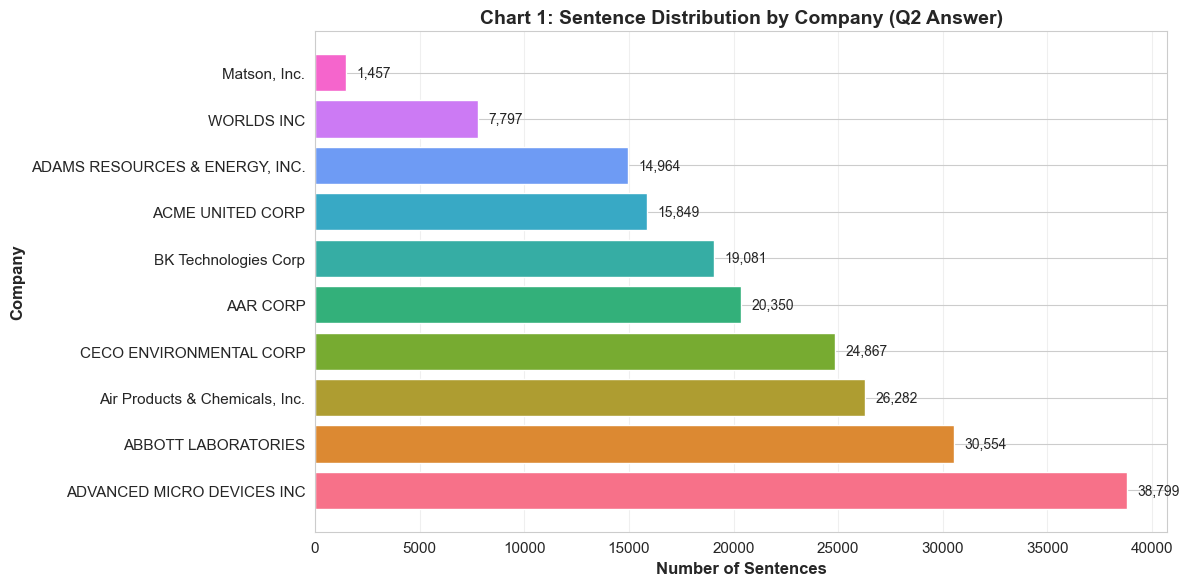

In [26]:
# Visualize company balance (bar chart)
fig, ax = plt.subplots(figsize=(12, 6))

companies = company_stats_pd['name'].tolist()
counts = company_stats_pd['sentence_count'].tolist()

bars = ax.barh(companies, counts, color=sns.color_palette("husl", 10))
ax.set_xlabel('Number of Sentences', fontsize=12, fontweight='bold')
ax.set_ylabel('Company', fontsize=12, fontweight='bold')
ax.set_title('Chart 1: Sentence Distribution by Company (Q2 Answer)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 500, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
# Answer Q3: Temporal distribution
# Extract year from reportDate
df_temporal = df.with_columns([
    pl.col("reportDate").str.strptime(pl.Date, "%Y-%m-%d").alias("report_date_parsed")
]).with_columns([
    pl.col("report_date_parsed").dt.year().alias("year")
])

# Sentences per year
year_stats = (
    df_temporal.group_by("year")
    .agg([
        pl.count("sentence").alias("sentence_count"),
        pl.n_unique("docID").alias("num_filings")
    ])
    .sort("year")
)

year_stats_pd = year_stats.to_pandas()

display_table_with_html(
    year_stats_pd,
    title="Table 4: Temporal Distribution by Year (Answers Q3: Date Range)"
)

# Summary stats
print(f"\n📅 Temporal Coverage:")
print(f"   Earliest year: {year_stats_pd['year'].min()}")
print(f"   Latest year: {year_stats_pd['year'].max()}")
print(f"   Total span: {year_stats_pd['year'].max() - year_stats_pd['year'].min() + 1} years")
print(f"   Average sentences/year: {year_stats_pd['sentence_count'].mean():,.0f}")

,year,sentence_count,num_filings
0,1993,853,2
1,1994,1257,3
2,1995,1135,3
3,1996,1211,3
4,1997,1510,3
5,1998,1365,3
6,1999,370,1
7,2000,1181,2
8,2001,1298,3
9,2002,6361,7



📅 Temporal Coverage:
   Earliest year: 1993
   Latest year: 2020
   Total span: 28 years
   Average sentences/year: 7,143


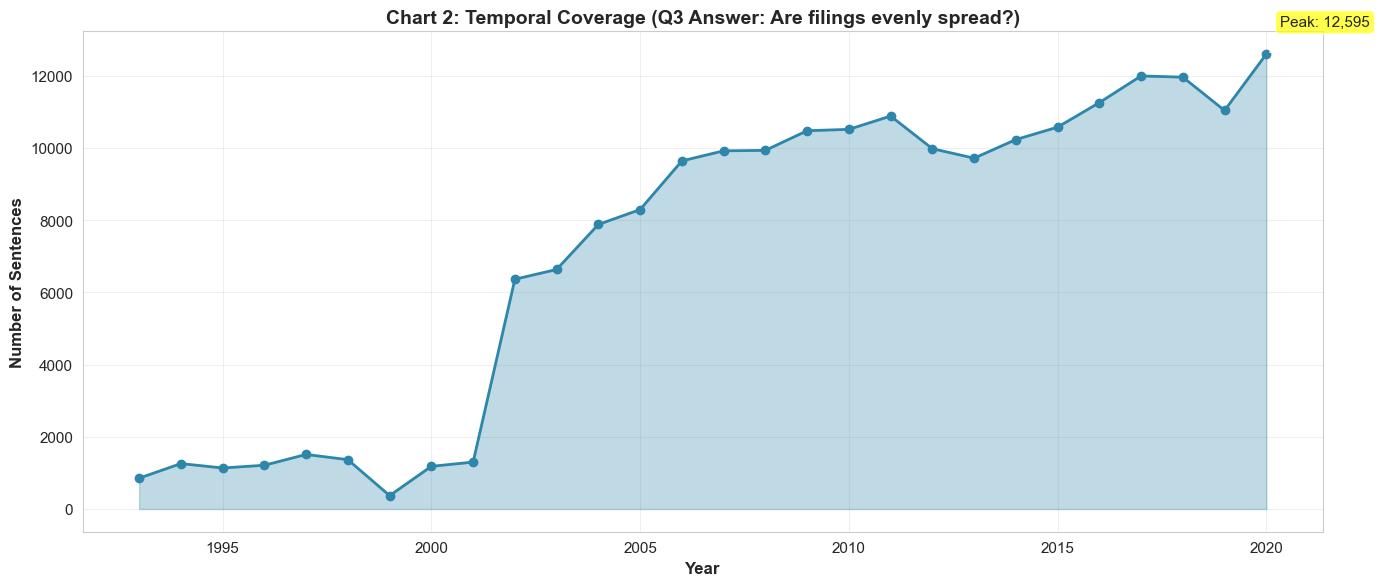

In [28]:
# Chart 2: Sentences over time
fig, ax = plt.subplots(figsize=(14, 6))

years = year_stats_pd['year'].tolist()
counts = year_stats_pd['sentence_count'].tolist()

ax.plot(years, counts, marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax.fill_between(years, counts, alpha=0.3, color='#2E86AB')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Sentences', fontsize=12, fontweight='bold')
ax.set_title('Chart 2: Temporal Coverage (Q3 Answer: Are filings evenly spread?)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotations for min/max years
max_idx = counts.index(max(counts))
min_idx = counts.index(min(counts))
ax.annotate(f'Peak: {max(counts):,}', xy=(years[max_idx], counts[max_idx]), 
            xytext=(10, 20), textcoords='offset points',
            bbox=dict(boxstyle='round', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

In [29]:
# Answer Q1: What are the 20 section codes?
section_stats = (
    df.group_by("section")
    .agg([
        pl.count("sentence").alias("sentence_count"),
        pl.n_unique("cik").alias("num_companies")
    ])
    .sort("section")
)

section_stats_pd = section_stats.to_pandas()

# Add percentage
section_stats_pd['percentage'] = (section_stats_pd['sentence_count'] / len(df) * 100).round(2)

display_table_with_html(
    section_stats_pd,
    title="Table 5: Section Code Distribution (Answers Q1: What are the 20 codes?)"
)

print(f"\n🔍 Section Analysis:")
print(f"   Expected sections: 0-9 (10 codes)")
print(f"   Actual sections: {section_stats_pd['section'].min()} to {section_stats_pd['section'].max()} ({len(section_stats_pd)} codes)")
print(f"   Section coverage: {section_stats_pd['num_companies'].min()}-{section_stats_pd['num_companies'].max()} companies per section")

,section,sentence_count,num_companies,percentage
0,0,21311,9,10.66
1,1,24627,10,12.31
2,2,374,9,0.19
3,3,2317,9,1.16
4,4,4534,10,2.27
5,5,3893,10,1.95
6,6,2836,10,1.42
7,7,1355,9,0.68
8,8,47677,10,23.84
9,9,3993,9,2.00



🔍 Section Analysis:
   Expected sections: 0-9 (10 codes)
   Actual sections: 0 to 19 (20 codes)
   Section coverage: 9-10 companies per section


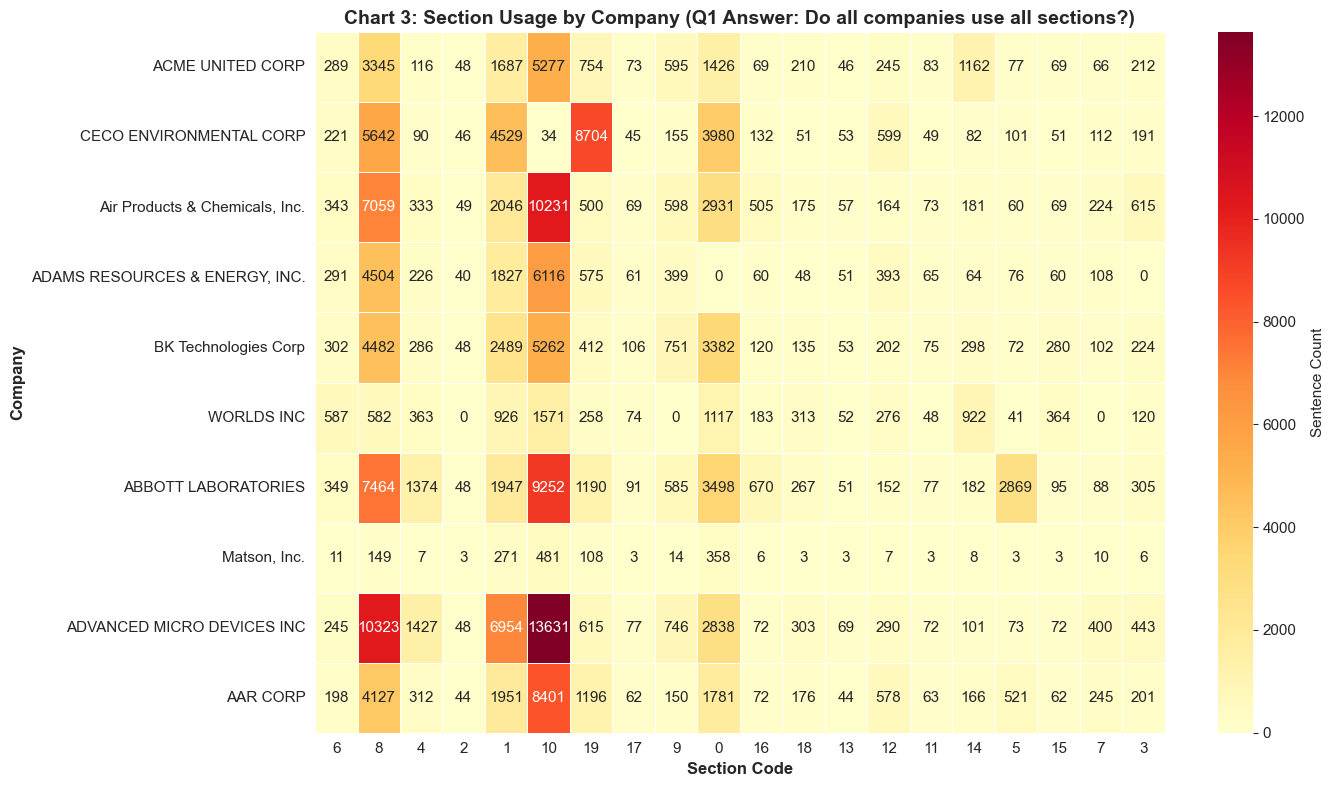

In [30]:
# Cross-tab: Which companies use which sections?
section_company_cross = (
    df.group_by(["section", "name"])
    .agg(pl.count("sentence").alias("count"))
    .pivot(index="name", columns="section", values="count")
    .fill_null(0)
)

section_company_pd = section_company_cross.to_pandas().set_index('name')

# Heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(section_company_pd, annot=True, fmt='.0f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Sentence Count'}, ax=ax)
ax.set_title('Chart 3: Section Usage by Company (Q1 Answer: Do all companies use all sections?)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Section Code', fontsize=12, fontweight='bold')
ax.set_ylabel('Company', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

📊 Token Length Statistics:
   Mean: 25.8 tokens
   Median: 22 tokens
   95th percentile: 55 tokens
   Max: 737 tokens


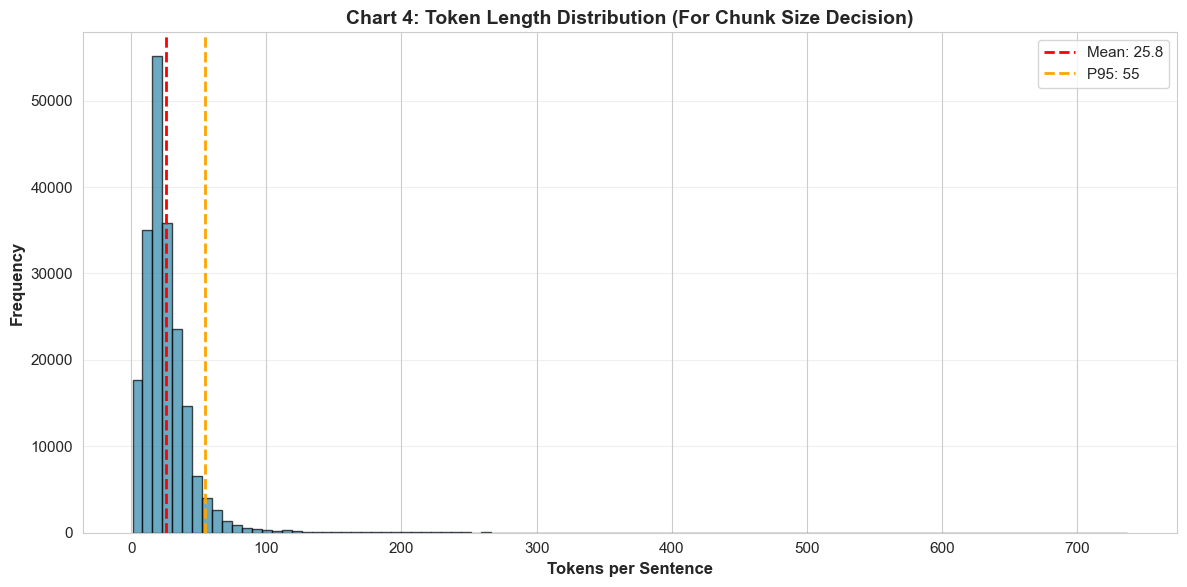


💡 Chunk Size Recommendation:
   3-sentence chunks: ~77 tokens (avg)
   5-sentence chunks: ~129 tokens (avg)
   Embedding limit (512 tokens): Fits ~19.9 sentences


In [31]:
# Token length analysis (word-based tokenization)
import nltk
nltk.download('punkt', quiet=True)

# Calculate token counts
token_counts = df.with_columns([
    pl.col("sentence").str.split(" ").list.len().alias("token_count")
])

# Statistics
token_stats = token_counts.select([
    pl.col("token_count").mean().alias("mean"),
    pl.col("token_count").median().alias("median"),
    pl.col("token_count").quantile(0.95).alias("p95"),
    pl.col("token_count").max().alias("max"),
    pl.col("token_count").min().alias("min")
]).to_pandas()

print("📊 Token Length Statistics:")
print(f"   Mean: {token_stats['mean'][0]:.1f} tokens")
print(f"   Median: {token_stats['median'][0]:.0f} tokens")
print(f"   95th percentile: {token_stats['p95'][0]:.0f} tokens")
print(f"   Max: {token_stats['max'][0]:.0f} tokens")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
token_data = token_counts.select("token_count").to_pandas()['token_count']

ax.hist(token_data, bins=100, color='#2E86AB', alpha=0.7, edgecolor='black')
ax.axvline(token_stats['mean'][0], color='red', linestyle='--', linewidth=2, label=f"Mean: {token_stats['mean'][0]:.1f}")
ax.axvline(token_stats['p95'][0], color='orange', linestyle='--', linewidth=2, label=f"P95: {token_stats['p95'][0]:.0f}")
ax.set_xlabel('Tokens per Sentence', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Chart 4: Token Length Distribution (For Chunk Size Decision)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Chunk size recommendation
print(f"\n💡 Chunk Size Recommendation:")
print(f"   3-sentence chunks: ~{token_stats['mean'][0] * 3:.0f} tokens (avg)")
print(f"   5-sentence chunks: ~{token_stats['mean'][0] * 5:.0f} tokens (avg)")
print(f"   Embedding limit (512 tokens): Fits ~{512 / token_stats['mean'][0]:.1f} sentences")

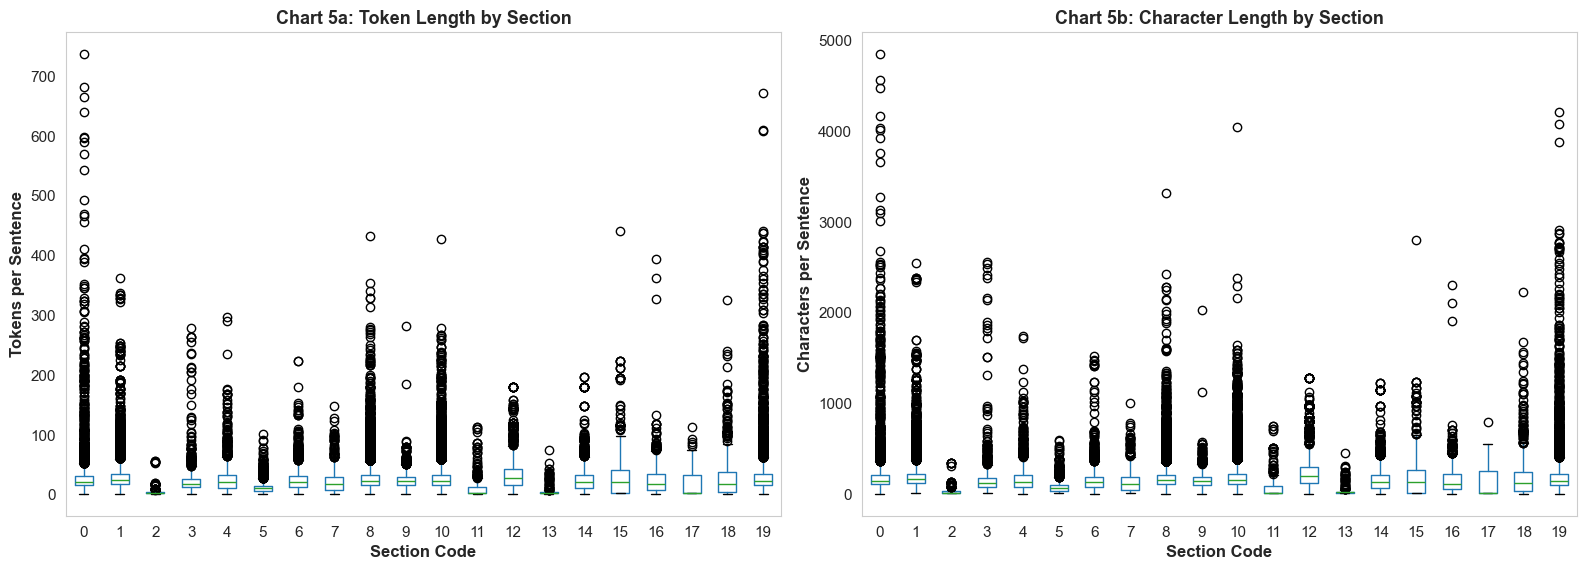

In [32]:
# Text length by section
section_text_stats = df.with_columns([
    pl.col("sentence").str.len_chars().alias("char_count"),
    pl.col("sentence").str.split(" ").list.len().alias("token_count")
]).select(["section", "char_count", "token_count"])

section_text_pd = section_text_stats.to_pandas()

# Boxplot for token count by section
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Token count boxplot
section_text_pd.boxplot(column='token_count', by='section', ax=axes[0], grid=False)
axes[0].set_xlabel('Section Code', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tokens per Sentence', fontsize=12, fontweight='bold')
axes[0].set_title('Chart 5a: Token Length by Section', fontsize=13, fontweight='bold')
axes[0].get_figure().suptitle('')  # Remove default title

# Char count boxplot
section_text_pd.boxplot(column='char_count', by='section', ax=axes[1], grid=False)
axes[1].set_xlabel('Section Code', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Characters per Sentence', fontsize=12, fontweight='bold')
axes[1].set_title('Chart 5b: Character Length by Section', fontsize=13, fontweight='bold')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

In [33]:
# Detailed stats by section
section_density = (
    df.with_columns([
        pl.col("sentence").str.len_chars().alias("char_count"),
        pl.col("sentence").str.split(" ").list.len().alias("token_count")
    ])
    .group_by("section")
    .agg([
        pl.col("char_count").mean().alias("avg_chars"),
        pl.col("token_count").mean().alias("avg_tokens"),
        pl.col("char_count").median().alias("median_chars"),
        pl.col("token_count").median().alias("median_tokens"),
        pl.col("char_count").max().alias("max_chars"),
        pl.col("token_count").max().alias("max_tokens"),
        pl.count("sentence").alias("sentence_count")
    ])
    .sort("section")
)

section_density_pd = section_density.to_pandas()
section_density_pd = section_density_pd.round(1)

display_table_with_html(
    section_density_pd,
    title="Table 6: Text Density by Section (Item 7 vs Item 1A Comparison)"
)

# Highlight extremes
densest_section = section_density_pd.loc[section_density_pd['avg_tokens'].idxmax(), 'section']
sparsest_section = section_density_pd.loc[section_density_pd['avg_tokens'].idxmin(), 'section']

print(f"\n🔍 Density Analysis:")
print(f"   Densest section: {densest_section} ({section_density_pd.loc[section_density_pd['avg_tokens'].idxmax(), 'avg_tokens']:.1f} avg tokens)")
print(f"   Sparsest section: {sparsest_section} ({section_density_pd.loc[section_density_pd['avg_tokens'].idxmin(), 'avg_tokens']:.1f} avg tokens)")

,section,avg_chars,avg_tokens,median_chars,median_tokens,max_chars,max_tokens,sentence_count
0,0,174.2,25.4,145.0,21.0,4850,737,21311
1,1,182.5,27.7,160.0,24.0,2544,362,24627
2,2,27.6,4.5,8.0,2.0,342,55,374
3,3,140.4,20.7,116.0,18.0,2557,279,2317
4,4,152.0,23.6,131.0,21.0,1743,296,4534
5,5,74.6,11.6,68.0,10.0,596,101,3893
6,6,149.2,23.5,127.0,20.0,1515,223,2836
7,7,129.7,20.5,112.0,18.0,1002,147,1355
8,8,168.8,26.0,148.0,23.0,3317,433,47677
9,9,146.2,22.7,140.0,22.0,2031,281,3993



🔍 Density Analysis:
   Densest section: 12 (33.4 avg tokens)
   Sparsest section: 2 (4.5 avg tokens)


In [34]:
# Identify extreme outliers (likely tables)
outliers = df.with_columns([
    pl.col("sentence").str.len_chars().alias("char_count")
]).filter(
    pl.col("char_count") > 1000  # Threshold for "table-like" text
).select(["section", "char_count", "sentence"]).head(5)

outliers_pd = outliers.to_pandas()

print("⚠️ Outlier Examples (Likely Tables/Lists):")
for idx, row in outliers_pd.iterrows():
    print(f"\n   Section {row['section']} | {row['char_count']} chars")
    print(f"   Preview: {row['sentence'][:150]}...")

⚠️ Outlier Examples (Likely Tables/Lists):

   Section 1 | 1174 chars
   Preview: Consequently, we are subject to a variety of risks that are specific to international operations, including the following: ●military conflicts, civil ...

   Section 10 | 1022 chars
   Preview: Sales by segment for these customers are as follows: AAR CORP. AND SUBSIDIARIES NOTES TO CONSOLIDATED FINANCIAL STATEMENTS (Continued) (Dollars in mil...

   Section 12 | 1040 chars
   Preview: The Company’s internal control over financial reporting is a process designed by, or under the supervision of, our Chief Executive Officer and Chief F...

   Section 19 | 1330 chars
   Preview: 4.3 Description of Capital Stock (filed herewith) 4.4 Rights Agreement, dated as of March 30, 2020, by and between AAR CORP. and Computershare Trust C...

   Section 19 | 1850 chars
   Preview: Material Contracts 10.1* Amended and Restated AAR CORP. Stock Benefit Plan effective October 1, 2001 (incorporated by reference to Exhibit 10.

## Next EDA acts: 
1. Top n-grams by section
2. Approx. duplication by section (simple, fast SimHash-style approach; no extra deps)
3. KPI signal scan (where numbers/units live, by section)
4. Section label suggestions (human labels from n-gram signatures)

In [39]:
# --- imports & config ---
import os, re, hashlib, random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# path to your parquet sample (adjust if needed)
PARQUET_PATH = os.getenv(
    "FINRAG_PARQUET",
    r"D:\JoelDesktop folds_24\NEU FALL2025\MLops IE7374 Project\finrag-insights-mlops\data\exports\sec_filings_small_full.parquet"
)
SAVE_CSV = True  # set True to save outputs in data/eda/

os.makedirs("data/eda", exist_ok=True)

# --- load df ---
df = pd.read_parquet(PARQUET_PATH)
df["sentence"] = df["sentence"].astype(str)
df["section"] = df["section"].astype(int)

# --- tiny helpers ---
tok_re = re.compile(r"[A-Za-z0-9%$\.]+")
def toks(s: str): return tok_re.findall((s or "").lower())

def shingles(tokens, k=5):
    if len(tokens) < k: return [" ".join(tokens)] if tokens else []
    return [" ".join(tokens[i:i+k]) for i in range(len(tokens)-k+1)]

def simhash64(tokens, bits=64):
    # simple simhash on tokens
    v = [0]*bits
    for t in tokens:
        h = int(hashlib.md5(t.encode()).hexdigest(), 16)
        for b in range(bits):
            v[b] += 1 if (h>>b)&1 else -1
    x = 0
    for b in range(bits):
        if v[b] >= 0: x |= (1<<b)
    return x

def hamming(a, b): return (a ^ b).bit_count()


In [40]:
# params
NGRAM_RANGE = (1, 2)
TOP_K = 25
MIN_DF = 5
MAX_DF = 0.6
SAMPLE_PER_SECTION = 12000  # keep fast; adjust as needed

rows = []
for sec, grp in df.groupby("section"):
    sub = grp["sentence"]
    if len(sub) == 0: continue
    if len(sub) > SAMPLE_PER_SECTION:
        sub = sub.sample(SAMPLE_PER_SECTION, random_state=13)

    vect = TfidfVectorizer(tokenizer=toks, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF, lowercase=True)
    try:
        X = vect.fit_transform(sub.values)
    except ValueError:
        continue

    vocab = np.array(sorted(vect.vocabulary_, key=vect.vocabulary_.get))
    scores = np.asarray(X.mean(axis=0)).ravel()
    top_idx = np.argsort(scores)[::-1][:TOP_K]
    for rank, j in enumerate(top_idx, 1):
        rows.append({"section": sec, "ngram": vocab[j], "score": float(scores[j]), "rank": rank})

ngrams_df = pd.DataFrame(rows).sort_values(["section","rank"]).reset_index(drop=True)
display(ngrams_df.head(20))

if SAVE_CSV:
    path = "data/eda/top_ngrams_by_section.csv"
    ngrams_df.to_csv(path, index=False)
    print("saved:", path)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


saved: data/eda/top_ngrams_by_section.csv


In [41]:
# params
NGRAM_RANGE = (1, 2)
TOP_K = 25
MIN_DF = 5
MAX_DF = 0.6
SAMPLE_PER_SECTION = 12000  # keep fast; adjust as needed

rows = []
for sec, grp in df.groupby("section"):
    sub = grp["sentence"]
    if len(sub) == 0: continue
    if len(sub) > SAMPLE_PER_SECTION:
        sub = sub.sample(SAMPLE_PER_SECTION, random_state=13)

    vect = TfidfVectorizer(tokenizer=toks, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF, lowercase=True)
    try:
        X = vect.fit_transform(sub.values)
    except ValueError:
        continue

    vocab = np.array(sorted(vect.vocabulary_, key=vect.vocabulary_.get))
    scores = np.asarray(X.mean(axis=0)).ravel()
    top_idx = np.argsort(scores)[::-1][:TOP_K]
    for rank, j in enumerate(top_idx, 1):
        rows.append({"section": sec, "ngram": vocab[j], "score": float(scores[j]), "rank": rank})

ngrams_df = pd.DataFrame(rows).sort_values(["section","rank"]).reset_index(drop=True)
display(ngrams_df.head(20))

if SAVE_CSV:
    path = "data/eda/top_ngrams_by_section.csv"
    ngrams_df.to_csv(path, index=False)
    print("saved:", path)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


saved: data/eda/top_ngrams_by_section.csv


In [42]:
# params
SAMPLE_PER_SECTION_DUP = 6000
SHINGLE_K = 5
PREFIX_BITS = 16          # bucket by first 16 bits
HAMMING_THRESHOLD = 3     # pairs within a bucket considered near-dup if <= 3 bits
PAIR_CHECK_LIMIT = 8000   # cap pair checks per bucket to keep fast

dup_rows = []
for sec, grp in df.groupby("section"):
    texts = grp["sentence"]
    if len(texts) == 0:
        dup_rows.append({"section": sec, "n_sampled": 0, "n_near_dupes": 0, "dup_rate": 0.0})
        continue
    if len(texts) > SAMPLE_PER_SECTION_DUP:
        texts = texts.sample(SAMPLE_PER_SECTION_DUP, random_state=17)

    # build simhash buckets
    buckets = defaultdict(list)
    for s in texts:
        tokens = toks(s)
        sh = shingles(tokens, k=SHINGLE_K) or tokens
        hv = simhash64(sh or [""])
        prefix = hv >> (64 - PREFIX_BITS)
        buckets[prefix].append(hv)

    n = len(texts)
    near_dupes = 0
    for _, vals in buckets.items():
        m = len(vals)
        if m <= 1: continue
        # sample limited pairs inside bucket
        idxs = list(range(m))
        checked = 0
        # simple random sampling of pairs
        for i in range(m):
            for j in range(i+1, m):
                if checked >= PAIR_CHECK_LIMIT: break
                if hamming(vals[i], vals[j]) <= HAMMING_THRESHOLD:
                    near_dupes += 1
                checked += 1
            if checked >= PAIR_CHECK_LIMIT: break

    dup_rows.append({"section": sec, "n_sampled": int(n), "n_near_dupes": int(near_dupes), "dup_rate": round(near_dupes/max(1,n), 4)})

dup_df = pd.DataFrame(dup_rows).sort_values("section").reset_index(drop=True)
display(dup_df.head(20))

if SAVE_CSV:
    path = "data/eda/duplication_by_section.csv"
    dup_df.to_csv(path, index=False)
    print("saved:", path)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


saved: data/eda/duplication_by_section.csv


In [43]:
# KPI signal scan (what % of sentences carry numeric/scale cues)
PATTERNS = {
    "currency": re.compile(r"(\$|usd|us\$)\s?\d[\d,]*\.?\d*", re.I),
    "percent": re.compile(r"\b\d{1,3}\.\d+%|\b\d{1,3}%"),
    "eps": re.compile(r"\beps\b|\bearnings per share\b", re.I),
    "units": re.compile(r"in (thousands|millions|billions)", re.I),
    "yoy": re.compile(r"\b(year[- ]over[- ]year|yoy)\b", re.I),
    "growth": re.compile(r"\b(increase[d]?|decrease[d]?|grew|declined)\b", re.I),
}
SAMPLE_PER_SECTION_KPI = 15000

kpi_rows = []
for sec, grp in df.groupby("section"):
    texts = grp["sentence"]
    if len(texts) == 0: continue
    if len(texts) > SAMPLE_PER_SECTION_KPI:
        texts = texts.sample(SAMPLE_PER_SECTION_KPI, random_state=23)
    n = len(texts)
    counts = Counter()
    for s in texts:
        s_low = s.lower()
        for k, pat in PATTERNS.items():
            if pat.search(s_low): counts[k] += 1
    row = {"section": sec, "n": n}
    for k in PATTERNS.keys(): row[f"pct_{k}"] = round(100.0 * counts[k] / n, 2)
    kpi_rows.append(row)

kpi_df = pd.DataFrame(kpi_rows).sort_values("section").reset_index(drop=True)
display(kpi_df.head(20))

if SAVE_CSV:
    path = "data/eda/kpi_signal_scan_by_section.csv"
    kpi_df.to_csv(path, index=False); print("saved:", path)

# Section label suggestions from top n-grams
LABEL_HINTS = [
    ("Business / Overview", ("business","segment","customers","products","overview")),
    ("Risk Factors", ("risk","risks","adverse","uncertain")),
    ("MD&A (Discussion & Analysis)", ("management","discussion","analysis","operations","md&a")),
    ("Financial Statements / Notes", ("consolidated","statement","net","sales","revenue","income","note")),
    ("Controls & Procedures", ("controls","disclosure","procedures","internal control")),
    ("Legal / Exhibits", ("exhibit","agreement","incorporated","reference","schedule")),
]

label_rows = []
for sec, grp in ngrams_df.groupby("section"):
    top_terms = grp.sort_values("rank").head(15)["ngram"].tolist()
    best_label, best_hits = "Unclear", []
    best_count = -1
    for label, keys in LABEL_HINTS:
        hits = [k for k in keys if any(k in t for t in top_terms)]
        if len(hits) > best_count:
            best_count, best_label, best_hits = len(hits), label, hits
    label_rows.append({"section": sec, "guess_label": best_label if best_count>0 else "Unclear", "support_terms": ", ".join(best_hits)})

labels_df = pd.DataFrame(label_rows).sort_values("section").reset_index(drop=True)
display(labels_df)

if SAVE_CSV:
    path = "data/eda/section_label_suggestions.csv"
    labels_df.to_csv(path, index=False); print("saved:", path)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


saved: data/eda/kpi_signal_scan_by_section.csv


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


saved: data/eda/section_label_suggestions.csv


In [7]:
from pathlib import Path
import pyarrow as pa

ARROW_DIR = Path("D:/JoelDesktop folds_24/NEU FALL2025/MLops IE7374 Project/finrag-insights-mlops/data/temp_large_download/JanosAudran___financial-reports-sec/large_full/1.1.1/e9328f71b08580052f4ba03a561977d78e8024c5257d4a71bb465988b4a71b47")

# List all files
files = list(ARROW_DIR.glob("*"))
print(f"Total files: {len(files)}\n")

# Categorize by extension
extensions = {}
for f in files:
    ext = f.suffix if f.suffix else 'no_extension'
    extensions[ext] = extensions.get(ext, 0) + 1

print("File types:")
for ext, count in sorted(extensions.items()):
    print(f"  {ext}: {count} files")

# Show first 5 filenames
print(f"\nFirst 5 files:")
for f in files[:5]:
    print(f"  {f.name}")


from pathlib import Path
import pyarrow.ipc as ipc

ARROW_DIR = Path("D:/JoelDesktop folds_24/NEU FALL2025/MLops IE7374 Project/finrag-insights-mlops/data/temp_large_download/JanosAudran___financial-reports-sec/large_full/1.1.1/e9328f71b08580052f4ba03a561977d78e8024c5257d4a71bb465988b4a71b47")

arrow_files = sorted(ARROW_DIR.glob("*.arrow"))

print(f"Checking {len(arrow_files)} files...\n")

corrupted = []
total_rows = 0

for i, f in enumerate(arrow_files):
    try:
        reader = ipc.open_stream(f)  # Try stream format instead of file format
        table = reader.read_all()
        rows = len(table)
        total_rows += rows
        if i % 20 == 0:
            print(f"  ✓ Shard {i+1}/{len(arrow_files)}: {rows:,} rows")
    except Exception as e:
        print(f"  ✗ CORRUPTED: {f.name} - {e}")
        corrupted.append(f.name)

print(f"\nResults:")
print(f"  Total rows: {total_rows:,}")
print(f"  Corrupted files: {len(corrupted)}")

if corrupted:
    print(f"\n⚠️ These files are corrupted:")
    for fname in corrupted:
        print(f"    {fname}")
else:
    print(f"\n✓ All files valid - safe to proceed with conversion")

Total files: 97

File types:
  .arrow: 95 files
  .json: 1 files
  no_extension: 1 files

First 5 files:
  dataset_info.json
  financial-reports-sec-test-00000-of-00004.arrow
  financial-reports-sec-test-00001-of-00004.arrow
  financial-reports-sec-test-00002-of-00004.arrow
  financial-reports-sec-test-00003-of-00004.arrow
Checking 95 files...

  ✓ Shard 1/95: 745,000 rows
  ✓ Shard 21/95: 756,000 rows
  ✓ Shard 41/95: 770,000 rows
  ✓ Shard 61/95: 768,000 rows
  ✓ Shard 81/95: 767,000 rows

Results:
  Total rows: 71,866,962
  Corrupted files: 0

✓ All files valid - safe to proceed with conversion


In [ ]:
from pathlib import Path
from datasets import load_dataset
import polars as pl
import shutil

TEMP_ROOT = Path("D:/JoelDesktop folds_24/NEU FALL2025/MLops IE7374 Project/finrag-insights-mlops/data/temp_large_download")
EXPORT_DIR = Path("D:/JoelDesktop folds_24/NEU FALL2025/MLops IE7374 Project/finrag-insights-mlops/data/exports")

print("Loading ALL splits (train + validation + test)...")

# Load all splits
ds_train = load_dataset(
    "JanosAudran/financial-reports-sec",
    "large_full",
    split="train",
    cache_dir=str(TEMP_ROOT)
)

ds_validation = load_dataset(
    "JanosAudran/financial-reports-sec",
    "large_full",
    split="validation",
    cache_dir=str(TEMP_ROOT)
)

ds_test = load_dataset(
    "JanosAudran/financial-reports-sec",
    "large_full",
    split="test",
    cache_dir=str(TEMP_ROOT)
)

print(f"Loaded:")
print(f"  Train: {len(ds_train):,} rows")
print(f"  Validation: {len(ds_validation):,} rows")
print(f"  Test: {len(ds_test):,} rows")
print(f"  Total: {len(ds_train) + len(ds_validation) + len(ds_test):,} rows")

# Convert each to Polars and concatenate
print("\nConverting to Polars...")
df_train = pl.from_arrow(ds_train.data.table)
df_val = pl.from_arrow(ds_validation.data.table)
df_test = pl.from_arrow(ds_test.data.table)

df = pl.concat([df_train, df_val, df_test])

# Metadata
print(f"\nCombined Dataset:")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {df.shape[1]}")
print(f"  Companies: {df.select(pl.n_unique('cik')).item()}")
print(f"  Sections: {df.select(pl.n_unique('section')).item()}")
print(f"  Memory: {df.estimated_size('gb'):.2f} GB")

# Save
output_path = EXPORT_DIR / "sec_filings_large_full.parquet"
print(f"\nSaving to Parquet...")

df.write_parquet(output_path, compression="zstd", compression_level=3)

final_size_gb = output_path.stat().st_size / (1024**3)
print(f"\nSaved: {output_path}")
print(f"Size: {final_size_gb:.2f} GB")
print(f"Compression: {44/final_size_gb:.1f}x")

# Cleanup
print(f"\nDelete 44GB? (y/n): ", end="")
if input().lower() == 'y':
    shutil.rmtree(TEMP_ROOT)
    print("Deleted temp_large_download/")

Loading ALL splits (train + validation + test)...


Loading dataset shards:   0%|          | 0/88 [00:00<?, ?it/s]

Loaded:
  Train: 67,316,227 rows
  Validation: 1,585,561 rows
  Test: 2,965,174 rows
  Total: 71,866,962 rows

Converting to Polars...

Combined Dataset:
  Rows: 71,866,962
  Columns: 19
  Companies: 4674
  Sections: 20
  Memory: 39.03 GB

Saving to Parquet...

Saved: D:\JoelDesktop folds_24\NEU FALL2025\MLops IE7374 Project\finrag-insights-mlops\data\exports\sec_filings_large_full.parquet
Size: 1.53 GB
Compression: 28.7x

Delete 44GB? (y/n): 

In [ ]:

## CODE deleted the 44GB temp folder after conversion.

# import shutil
# from pathlib import Path

# TEMP_ROOT = Path("D:/JoelDesktop folds_24/NEU FALL2025/MLops IE7374 Project/finrag-insights-mlops/data/temp_large_download")

# # Delete without prompt
# shutil.rmtree(TEMP_ROOT)
# print(f"Deleted {TEMP_ROOT}")
# print("Freed ~44GB")

Deleted D:\JoelDesktop folds_24\NEU FALL2025\MLops IE7374 Project\finrag-insights-mlops\data\temp_large_download
Freed ~44GB


In [1]:
import polars as pl

# Load both
df_small = pl.read_parquet("../data/exports/sec_filings_small_full.parquet")
df_large = pl.read_parquet("../data/exports/sec_filings_large_full.parquet")

# Basic comparison (Polars only, no Pandas conversion)
print("SMALL_FULL vs LARGE_FULL Comparison")
print("="*60)
print(f"Rows:      {len(df_small):>12,}  vs  {len(df_large):,}")
print(f"Companies: {df_small.select(pl.n_unique('cik')).item():>12,}  vs  {df_large.select(pl.n_unique('cik')).item():,}")
print(f"Sections:  {df_small.select(pl.n_unique('section')).item():>12}  vs  {df_large.select(pl.n_unique('section')).item()}")
print(f"Date start: {df_small.select(pl.col('reportDate').min()).item():>11}  vs  {df_large.select(pl.col('reportDate').min()).item()}")
print(f"Date end:   {df_small.select(pl.col('reportDate').max()).item():>11}  vs  {df_large.select(pl.col('reportDate').max()).item()}")

# Section distribution (Polars only)
print("\n\nSection Distribution:")
print(f"{'Sec':<5} {'Small %':>8} {'Large %':>8} {'Diff':>8}")
print("-"*35)

for sec in range(20):
    small_pct = (df_small.filter(pl.col('section') == sec).shape[0] / len(df_small)) * 100
    large_pct = (df_large.filter(pl.col('section') == sec).shape[0] / len(df_large)) * 100
    diff = large_pct - small_pct
    print(f"{sec:<5} {small_pct:>7.1f}% {large_pct:>7.1f}% {diff:>+7.1f}%")

: 